#### Major reference for SHAP values and some code directly used from https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html#Train-the-model

In [8]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
# print the JS visualization code to the notebook
shap.initjs()


### Load in the data.

In [9]:
# Access data store
data_store = pd.HDFStore('cleanedairbnbny.h5')

# Retrieve data using key
preprocessed_df = data_store['cleanedairbnbny']
data_store.close()

In [10]:
df = preprocessed_df

### Let's drop 'name' in this case as it has too many dummy variables. Typically, we will keep this in or try to feature engineer a different set of variables to represent this better. 

In [11]:
df = df[df.columns.drop(list(df.filter(regex='name')))]

In [12]:
print(df.shape)
df.head()

(38843, 6)


,reviews,availability_365,host_id,minimum_nights,longitude,latitude
0,0,365,2787,1,-73.97237,40.64749
1,0,355,2845,1,-73.98377,40.75362
3,1,194,4869,1,-73.95976,40.68514
4,0,0,7192,10,-73.94399,40.79851
5,0,129,7322,3,-73.97500,40.74767


### Change symbols in column names

In [13]:
df.columns = df.columns.str.replace("_", "")

### Run model on dataset 

In [14]:
import random
random.seed(1)
#store the result variable as separate df 
X = df.drop(columns = ['reviews'])
y = df['reviews']
#create train and test sets based on Close Rate of 17% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.17, random_state=1)
results1=dict()
results2=dict()
#fit model 
model = XGBClassifier()
#results stats
model.fit(X_train,y_train)
pred = model.predict(X_test)
results1[' Accuracy score'] = model.score(X_test,y_test)
results2[' F1 Score'] = f1_score(y_test, pred)
results2.update(results1)
resultDf = pd.DataFrame.from_dict(results2,orient = 'index')
print(resultDf)

                        0
 F1 Score        0.728111
 Accuracy score  0.767717


### Define prediction functions to be used later. 

In [15]:
#predict class: ClosedBooked = 1
def preds(X):
    results = model.predict(X)
    print(results)

#predict probability of being in each class
def probs(X):
    results = model.predict_proba(X)
    print(results)

In [16]:
#example
Xnew = pd.DataFrame(X_test.iloc[[0]])
preds(Xnew)
probs(Xnew)
#we see here that the model says there is a 3% chance for this opportunity to close

[0]
[[0.8105543  0.18944567]]


### Let's look at feature importance

In [17]:
importances = model.feature_importances_
impdf = pd.DataFrame({'features':X_test.columns,'importance':importances}).sort_values(by='importance',ascending=False)
print(impdf)

          features  importance
0  availability365    0.462497
2    minimumnights    0.420357
1           hostid    0.069046
3        longitude    0.025200
4         latitude    0.022900


### Can we create a function where we feed in the original values, then it converts to dummies and finally predicts this input? This will read in opportunity data that is already in a dataframe format. 

In [19]:
def predict_class_prob(listing):
    
    # Categorical boolean mask
    categorical_feature_mask = listing.dtypes==object

    # filter categorical columns using mask and turn it into a list
    categorical_cols = listing.columns[categorical_feature_mask].tolist()
    #save original versions of categorical columns for later
    catcols = listing[categorical_cols]

    listingdum = pd.get_dummies(listing,columns=catcols.columns.tolist())
    
    
    #create frame for df
    listing_format = (X_test.iloc[[0]]).copy()
    listing_format.iloc[[0]] = 0
    
    #append the values from the input to the right framework
    appenddfs = listing_format.append(listingdum, ignore_index=True, sort=False)
    appenddfs = appenddfs.fillna(0).iloc[[1]]
    
    
    #run model on re-formatted data
    print(preds(appenddfs))
    print(probs(appenddfs))

### Test that it's working correctly. 

In [20]:
listing_test = df.drop(columns = ["reviews"]).iloc[[2]]
predict_class_prob(listing_test)

[1]
None
[[0.42787385 0.57212615]]
None


### To visualize, let's look at SHAP values. These will help us see how each feature interacts with the likelihood of an opportunity closing. We can look at each feature one by one, or combinations of features. 

### Let's first look at the SHAP values feature by feature. 

In [21]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

In [22]:
X.iloc[[0]]

,availability365,hostid,minimumnights,longitude,latitude
0,365,2787,1,-73.97237,40.64749


In [24]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

### Visualize many predictions

In [25]:
#find random sample of 25 observations
idx = np.random.randint(18990, size=5)
#shap_values[idx,:]

In [26]:
#shap.force_plot(explainer.expected_value, shap_values[idx,:], X.iloc[:10,:])

### Bar Chart of Mean Importance

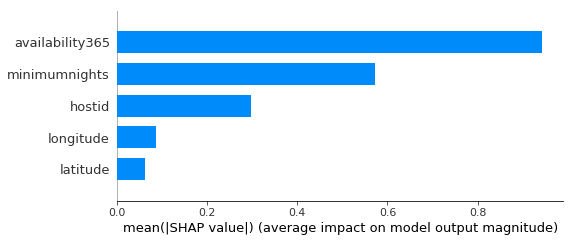

In [27]:
#This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X, plot_type="bar")

#### On average, the most important features in predicting Opportunity close are: Expected Quarters Open, Days in Current Stage, Opportunity Stage, if Adjusted Commitment is Forecast, Total Gross ASV, if Global Region is Japan, ARR, if Deployment Method is OnDemand, if Adjusted Commitment is Upside, if Deployment Method is PS - Consulting, etc. 

### SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

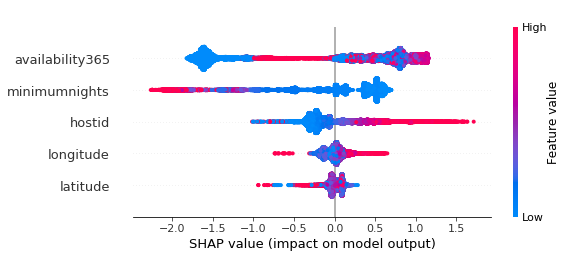

In [28]:
shap.summary_plot(shap_values, X)

### Example interpretation:
When a listing has less minimum nights, it more likely to have more than 1 review. 

### SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

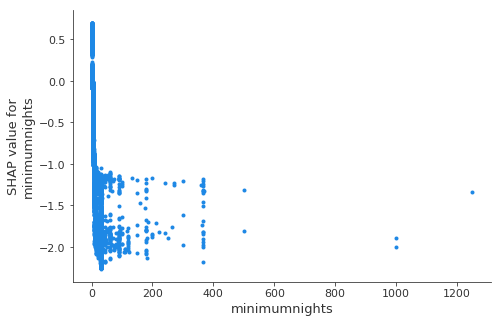

In [29]:
shap.dependence_plot("minimumnights", shap_values, X, interaction_index=None)

In [30]:
#selectedcolumns = ['Expected Quarters Open' , 'DaysInCurrentStage' , 'Stage_Converted' , 'NewAdjustedCommitment_Forecast' , 'Total_GrossASV']
#for name in selectedcolumns:
    #shap.dependence_plot(name, shap_values, X, display_features=X)

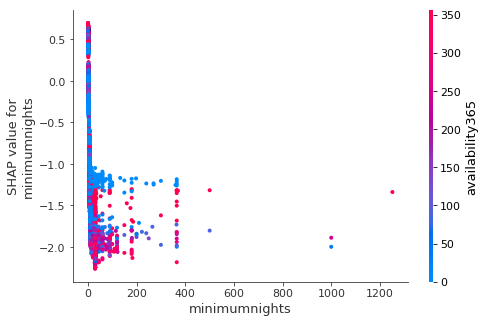

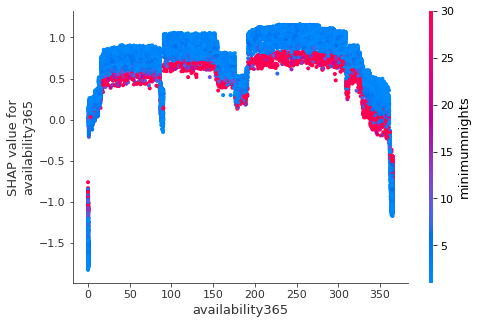

In [32]:
selectedcolumns = ['minimumnights','availability365']
for name in selectedcolumns:
    shap.dependence_plot(name, shap_values, X, display_features=X)

### Decision Plot

In [33]:
import warnings
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value

if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: -0.40221031677583596


In [34]:
select = range(100)
features = X_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[20]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[20]

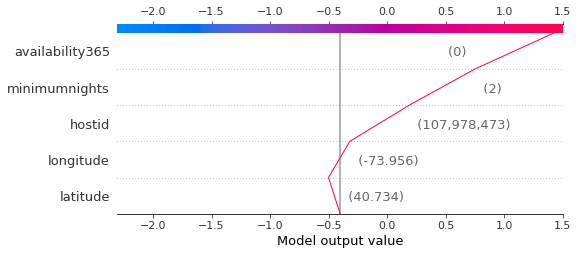

In [35]:
shap.decision_plot(expected_value, shap_values, features_display)